# 3. Modeling

In this section, I develop the models that will be used to understand in which state an asset is.

I have picked four models that based on my experience should perform quite well in cases such like these:

- Gradient boosting classifier
- Logistic regression
- Random forest classifier
- Support vector classifier

In [1]:
import datetime

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

## Loading the data

I start by loading the preprocessed dataset.

In [2]:
df_in = pd.read_parquet('../data/ml_dataset_preprocessed.parquet')

In [3]:
df_in.head()

,timestamp,device_id,voltage_freq_100,current_freq_50,current_freq_100,sensor_0,label
0,2020-04-05 23:00:00,158-000001956,3252.048729,516.200228,913.682622,24.148984,NaN
1,2020-01-15 16:30:00,158-000001326,-2128.635770,2510.892530,-70.144148,24.993833,NaN
2,2020-02-17 17:00:00,158-000000560,7452.666192,3750.525426,1705.408684,24.811650,NaN
3,2020-01-21 18:00:00,158-000000675,8348.201652,2755.585174,1308.747909,26.730441,NaN
4,2020-01-20 07:00:00,158-000001159,-2397.839620,3755.709244,-165.533040,24.530614,NaN


For this supervised learning problem, we need labeled data. I therefore drop the unlabeled data.

Another (or an additional) alternative could be to use the labels that I generated in the clustering phase. However, to keep this brief, I will not use that approach.

In [4]:
df_modeling = df_in.dropna().reset_index(drop=True)
df_modeling.shape

(5151, 7)

In [5]:
df_modeling.head()

,timestamp,device_id,voltage_freq_100,current_freq_50,current_freq_100,sensor_0,label
0,2020-02-24 04:00:00,158-000001415,6092.428085,252.875610,168.653323,16.735673,1.0
1,2020-01-22 02:30:00,158-000000675,6970.122300,3754.772438,1492.381809,30.359791,2.0
2,2020-04-01 03:00:00,158-000001005,-1919.316936,6183.555871,-286.589098,24.864819,3.0
3,2020-01-18 02:00:00,158-000001326,1453.100948,495.627072,505.063684,23.031433,1.0
4,2020-01-21 11:00:00,158-000000099,7886.164607,1002.673685,1400.965902,28.464941,2.0


I separate the features and the target (i.e. the label). Also, I drop the device_id and timestamp as these will not be used for modeling purposes.

In [6]:
X = df_modeling.drop(columns=['device_id', 'timestamp', 'label'])
y = df_modeling.label

## Train and test datasets

I split the data into a training set consisting of 75% of the observations, and an out-of-sample test set of 25%.

There are more thorough approaches to evaluating the model performance. In order to keep this brief, however, I will not take these approaches. Here are two of them:

__Cross-Validation__

- See [this link](https://scikit-learn.org/stable/modules/cross_validation.html) for a good overview of cross-validation and different approaches.

__Using both out-of-sample and out-of-time samples to validate the models__

- Out-of-sample sampling refers to the approach of randomly drawing test samples from the entire population.
- In out-of-time sampling, you split the dataset into two parts based on the timestamp of the observation: in-time and out-of-time. You then use the in-time sample to train the model and the out-of-time sample to test the model.
- It is good to use out-of-time sampling when you are dealing with time series. In this specific case, we could use out-of-time sampling to see if the behavior of the assets have changed in general over time.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Standardizing the data

The sensor data is on a different scale compared to the Fourier Transformed data. I therefore standardize the dataset so that one or more features don't get an overly big weight during the model estimation.

In [8]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Estimating the models

I estimate the models using their standard parameters. In a real-world setting, I would use parameter tuning to improve the model performance. Some good approaches are described [here](https://scikit-learn.org/stable/modules/grid_search.html). My personal favorite is RandomizedSearchCV.

Another (lazy) approach would be to use [TPOT](http://epistasislab.github.io/tpot/) to find the absolute best performing model. TPOT is resource-heavy though, and may not be good for the planet, your pockets or with big datasets.

Another fun approach would be to use a neural network approach, but as the dataset is fairly small and training a neural network requires some effort, the rewards would probably not match the efforts.

In [9]:
gradient_boosting = GradientBoostingClassifier(random_state=42)
logistic_regression = LogisticRegression(solver='lbfgs', random_state=42)
random_forest = RandomForestClassifier(random_state=42)
support_vector = SVC(random_state=42)

gradient_boosting.fit(X_train, y_train)
logistic_regression.fit(X_train, y_train)
random_forest.fit(X_train, y_train)
support_vector.fit(X_train, y_train)

y_pred_gb = gradient_boosting.predict(X_test)
y_pred_lr = logistic_regression.predict(X_test)
y_pred_rf = random_forest.predict(X_test)
y_pred_sv = support_vector.predict(X_test)

## Evaluating the models

In [10]:
print('--- Gradient Boosting ---')
print(f"Accuracy: {round(accuracy_score(y_test, y_pred_gb), 4)}")
print(f"F1 (weighted): {round(f1_score(y_test, y_pred_gb, average='weighted'), 4)}")
print('')
print('--- Logistic Regression ---')
print(f"Accuracy: {round(accuracy_score(y_test, y_pred_lr), 4)}")
print(f"F1 (weighted): {round(f1_score(y_test, y_pred_lr, average='weighted'), 4)}")
print('')
print('--- Random Forest ---')
print(f"Accuracy: {round(accuracy_score(y_test, y_pred_rf), 4)}")
print(f"F1 (weighted): {round(f1_score(y_test, y_pred_rf, average='weighted'), 4)}")
print('')
print('--- Support Vector ---')
print(f"Accuracy: {round(accuracy_score(y_test, y_pred_sv), 4)}")
print(f"F1 (weighted): {round(f1_score(y_test, y_pred_sv, average='weighted'), 4)}")

--- Gradient Boosting ---
Accuracy: 0.9736
F1 (weighted): 0.9736

--- Logistic Regression ---
Accuracy: 0.9752
F1 (weighted): 0.9751

--- Random Forest ---
Accuracy: 0.9798
F1 (weighted): 0.9798

--- Support Vector ---
Accuracy: 0.9767
F1 (weighted): 0.9767


The models achieve some pretty good accuracies. The random forest model performs the best, followed by the support vector model, the logistic regression model and the gradient boosting model.

I will add support for using any of these models in the python application, but the support vector model will be used by default.

In real life, one should analyze more thoroughly how the model works. For complex, more "black box" models, some common approaches are:

- [Shap](https://github.com/slundberg/shap)
- [Lime](https://github.com/marcotcr/lime)

In this exercise, however, I will limit myself to the feature importances of the random forest model, which are shown below.

Feature ranking:
1. voltage_freq_100 (0.420262)
2. current_freq_50 (0.325225)
3. current_freq_100 (0.232188)
4. sensor_0 (0.022325)


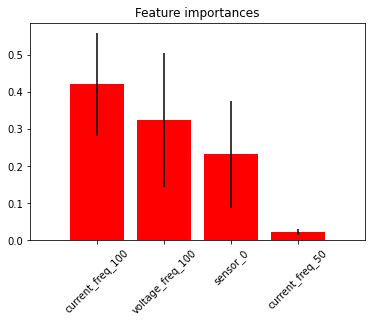

In [11]:
importances = random_forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in random_forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print(f"{f + 1}. {X.columns[f]} ({round(importances[indices[f]], 6)})")

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), [X.columns[i] for i in indices], rotation=45)
plt.xlim([-1, X.shape[1]])
plt.show()

Here we can see that the most important features are the current and voltage frequencies of 100Hz and sensor 0. The current frequency of 50Hz is far less important.

## Exporting the model artifacts

I export the model artifacts so that they can be used in the python application.

In [12]:
date = datetime.datetime.utcnow().strftime('%Y_%m_%d')
joblib.dump(gradient_boosting, f'../pdn_monitoring/models/gradient_boosting_{date}.joblib')
joblib.dump(logistic_regression, f'../pdn_monitoring/models/logistic_regression_{date}.joblib')
joblib.dump(random_forest, f'../pdn_monitoring/models/random_forest_{date}.joblib')
joblib.dump(support_vector, f'../pdn_monitoring/models/support_vector_{date}.joblib')

['../pdn_monitoring/models/support_vector_2021_04_19.joblib']